In [1]:
import anndata as ad  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pcdl
import os

In [42]:
mcdsts = pcdl.TimeSeries('../../../ABM_NLC-CLL/Physicell_NLCs-CLL/output/', settingxml='../../../ABM_NLC-CLL/Physicell_NLCs-CLL/output/NLC_CLL.xml', verbose = False) 
timesteps = mcdsts.get_mcds_list()

#Extract positions corresponding to days 1-13
positions = []
for days in range(0,14):
      hours = 24*days
      positions.append(hours)

#Initial CLL cells
initial = timesteps[0].get_cell_df(states=1)
CLL_initial = len(initial[(initial['cell_type']=="cancer")])
apoptotic_initial = len(initial[(initial['cell_type']=="apoptotic")])
dead_initial = len(initial[(initial['cell_type']=="dead")])

alive = [CLL_initial]
dead = [dead_initial]
apoptotic = [apoptotic_initial]
for i in range(1, len(positions)):
    step = timesteps[positions[i]].get_cell_df(states=1)
    number_alive = len(step[(step['cell_type']=='cancer')&(step['dead']==False)]) #step['dead'] is only a formality cause all cells are considered 'alive', 'dead' is another celltype for this model
    number_apoptotic = len(step[(step['cell_type']=='apoptotic')&(step['dead']==False)])
    number_dead = len(step[(step['cell_type']=='dead')&(step['dead']==False)])
    alive.append(number_alive)
    dead.append(number_dead)
    apoptotic.append(number_apoptotic)

CLL_alive = pd.Series(alive, name="Cells_alive")
CLL_apoptotic = pd.Series(apoptotic, name = "Cells_apoptotic")
CLL_dead = pd.Series(dead, name = "Cells_dead")

#viability at time t =  CLL alive at time t / (CLL alive + CLL apoptotic + CLL dead) at time t
viability = []
for i in range(len(CLL_alive)):
    number = (CLL_alive[i]/(CLL_alive[i]+CLL_apoptotic[i]+CLL_dead[i]))*100
    viability.append(number)

####Remove day 4, 5, 11, 12 because of experimental
viability = np.delete(viability, [4,5,11,12], axis=0)

viability = pd.Series(viability, name = "CLL viability")

#concentration at time t =  CLL alive at time t / (CLL initial)
concentration = []
for i in range(len(CLL_alive)):
    number = (CLL_alive[i]/CLL_initial)*100
    concentration.append(number)

####Remove day 4, 5, 11, 12 because of experimental
concentration = np.delete(concentration, [4,5,11,12], axis=0)

concentration = pd.Series(concentration, name = "CLL concentration")


/home/marcelo.hurtado/.local/lib/python3.10/site-packages/pcdl/pyMCDS.py:1216: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cell.loc[:,'current_death_model'].replace(ds_death_model, inplace=True)  # bue 20230614: this column looks like an artefact to me
/home/marcelo.hurtado/.local/lib/python3.10/site-packages/pcdl/pyMCDS.py:1217: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will 

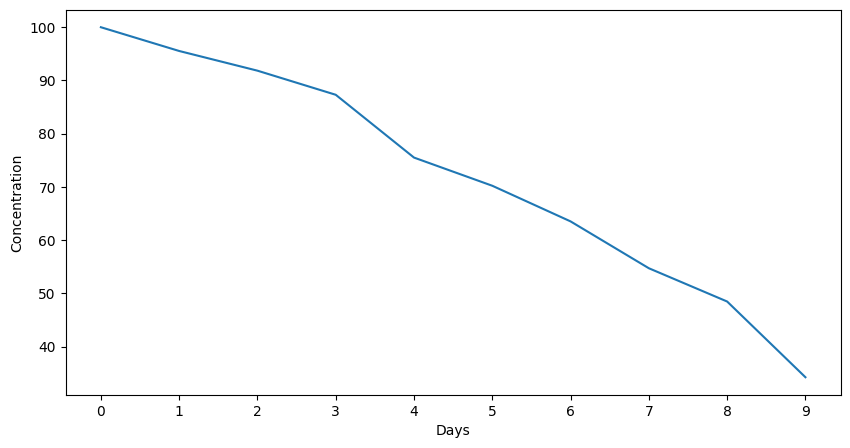

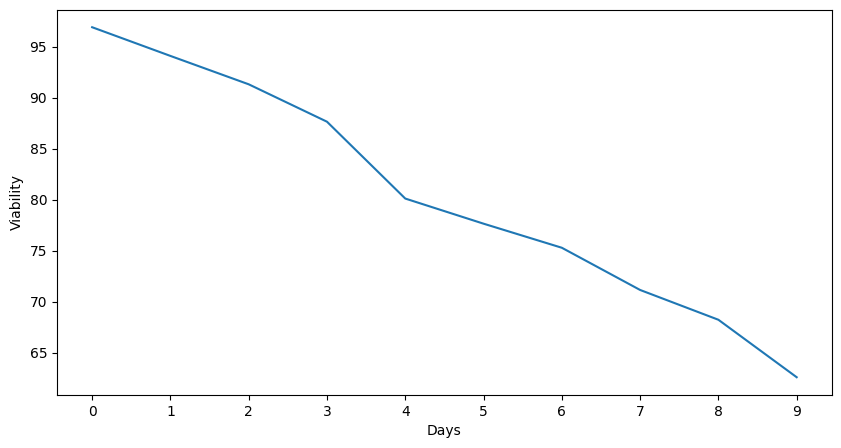

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
concentration.T.plot(kind='line', xlabel='Days', ylabel='Concentration', logy=False, ax=ax)  
ax.set_xticks(concentration.index)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
viability.T.plot(kind='line', xlabel='Days', ylabel='Viability', logy=False, ax=ax)  
ax.set_xticks(viability.index)
plt.show()

In [5]:
import xml.etree.ElementTree as ET
import pandas as pd

In [3]:
tree = ET.parse("../config/NLC_CLL.xml") #Load original xml file
root = tree.getroot()

In [7]:
thread_params = pd.read_csv("../data_output/Sensitivity_analysis/samples/Samples_0.csv")
thread_params = [tuple(row) for row in thread_params.itertuples(index=False, name=None)]

values = thread_params[0]
print(values)

(2.3202777933329344, 1.942960381507873, 0.0025737795826474, 1.0104484716430306, 0.0328546109913685, 2.385647683404386, 0.212276866659522, 1.8041692161932588)


In [ ]:
param_behaviors = {'cancer':{'secretion_rate': 0, 'speed': 1, 'transformation_rate': 2},
                'monocytes':{'speed': 3, 'transformation_rate': 4}, 
                'macrophages':{'relative_maximum_adhesion_distance': 5},
                'NLCs': {'speed': 6},
                'apoptotic':{'speed':7}}
    
for i, celltype in enumerate(param_behaviors.keys()): #i = number of keys name and celltype = cell type
    for param, column in param_behaviors[celltype].items(): #param = parameter name and column = column number
        if celltype == 'cancer' and param == 'uptake_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//*[@name='anti-apoptotic factor']//{param}") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'cancer' and param == 'secretion_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//*[@name='cancer-signal']//{param}") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'cancer' and param == 'transformation_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='apoptotic']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'cancer' and param == 'cell_adhesion_affinity':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='NLCs']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'monocytes' and param == 'transformation_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='macrophages']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'monocytes' and param == 'phagocytosis_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='apoptotic']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'macrophages' and param == 'phagocytosis_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='apoptotic']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'macrophages' and param == 'attack_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='cancer']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'macrophages' and param == 'cell_adhesion_affinity':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='cancer']") #Find the param name in XML file
            param_element.text = str(param_value)                    
        elif celltype == 'NLCs' and param == 'phagocytosis_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//*[@name='apoptotic']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'apoptotic' and param == 'secretion_rate':
            param_value = values[column]
            param_element = root.find(f".//*[@name='{celltype}']//substrate[@name='dead substrate']/{param}")
            param_element.text = str(param_value)
        elif celltype == 'apoptotic' and param == 'transformation_rate':
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}/[@name='dead']") #Find the param name in XML file
            param_element.text = str(param_value)
        elif celltype == 'dead' and param == 'secretion_rate':
            param_value = values[column]
            param_element = root.find(f".//*[@name='{celltype}']//substrate[@name='dead substrate']/{param}")
            param_element.text = str(param_value)    
        else:
            param_value = values[column] #Extract each value [i, col_index]
            param_element = root.find(f".//*[@name='{celltype}']//{param}") #Find the param name in XML file
            param_element.text = str(param_value)


In [ ]:
updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")